In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Flatten
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, CapsCNN, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (28, 28, 1)

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

test_augmentation = {
    'width_shift_range': 10,
    'height_shift_range': 10
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [5]:
model = Sequential([    
    Convolution2D(filters=128, kernel_size=(9, 9), padding='valid', activation='relu', input_shape=input_shape, name="Input"),
    Convolution2D(filters=32, kernel_size=(3, 3), padding='valid', activation="relu", strides=2, name="PrimaryCaps"),
    Activation(squash, name="Squash"),
    
    CapsCNN(16, kernel_size=(5, 5), routings=3, activation_caps=squash, name="ConvolutionalCaps"),
    
    Reshape((-1, 16), name='Flatten'),
    
    Caps(capsules=num_class, capsule_dim=12, routings=3, activation_caps=squash, name="Caps"),
    ClassesCaps(name='capsule'),
])
# plot_model(model, show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Conv2D)               (None, 20, 20, 128)       10496     
_________________________________________________________________
PrimaryCaps (Conv2D)         (None, 9, 9, 32)          36896     
_________________________________________________________________
Squash (Activation)          (None, 9, 9, 32)          0         
_________________________________________________________________
ConvolutionalCaps (CapsCNN)  (None, 5, 5, 16)          12800     
_________________________________________________________________
Flatten (Reshape)            (None, 25, 16)            0         
_________________________________________________________________
Caps (Caps)                  (None, 10, 12)            48000     
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total para

# Training

In [7]:
model.compile(optimizer=Adam(lr=1e-3),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=10,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3750/3750 [==============================] - 101s 27ms/step - loss: 0.2022 - categorical_accuracy: 0.7406 - val_loss: 0.0209 - val_categorical_accuracy: 0.9786
Epoch 2/10
3750/3750 [==============================] - 98s 26ms/step - loss: 0.0225 - categorical_accuracy: 0.9760 - val_loss: 0.0131 - val_categorical_accuracy: 0.9867
Epoch 3/10
3750/3750 [==============================] - 99s 26ms/step - loss: 0.0164 - categorical_accuracy: 0.9829 - val_loss: 0.0103 - val_categorical_accuracy: 0.9896
Epoch 4/10
3750/3750 [==============================] - 98s 26ms/step - loss: 0.0136 - categorical_accuracy: 0.9855 - val_loss: 0.0086 - val_categorical_accuracy: 0.9902
Epoch 5/10
3750/3750 [==============================] - 99s 26ms/step - loss: 0.0122 - categorical_accuracy: 0.9869 - val_loss: 0.0088 - val_categorical_accuracy: 0.9895
Epoch 6/10
3750/3750 [==============================] - 98s 26ms/step - loss: 0.0109 - categorical_ac

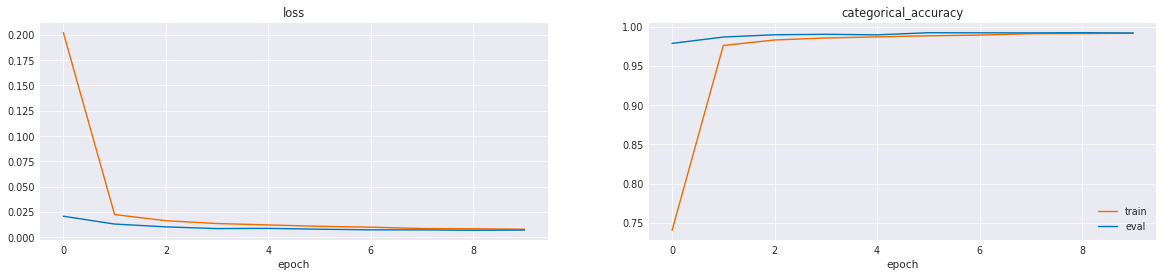

In [9]:
plotHistory(hist.history)
plt.savefig('mnist_CNN.png')